In [142]:
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import pickle

import swimAD2 as ad2       # copy swimAD2.py to your working directory
import time

ad2.disconnect()            # close all instances before connecting
zoroku = ad2.connect(0)      # connect to first(0th) ad2, give it the name 'zoroku'

We start by assuming that the two resistances were given. We also take the time interval of the measurement as a fixed given. 

Have a list of input voltages. For each input voltage, measure the voltages on scope 1 and scope 2 from start to finish of the measurement range. Here, mind the time steps of measurements.



In [143]:
# Set the measurement parameters. 

# Values of the resistances in Ohms. 
res1 = 1000 # Stanndard resistance
res2 = 10 # Device Under Test

def prepare_measurement(inpt,hertz,points):
    ad2.config_wavegen(
        zoroku,                                    # name of device
        frequency=200e3,                           # max 10 MHz
        amplitude=inpt,                              # max 5 V
        signal_shape=ad2.dwfc.funcSine ,         # output signal shape: funcSine, funcSquare, funcTriangle, funcRampUp, funcRampDown, funcNoise
        # offset=0,                               # signal voltage offset
        # phase=0,                                # signal phase
        # symmetry=50,                            # signal symmetry shape
        # channel=0                               # channel 0 / 1 (or -1 for all channels)
    )
    
    ad2.config_oscilloscope(
        zoroku,                        # name of device
        range0=.25,                     # Oscilloscope Channel 0 voltage range, max 25 V
        range1=.25,                     # Oscilloscope Channel 2
        sample_rate=hertz,           # max 100 MHz
        sample_size=points,           # max 8192, sample time = sample_size / sample_rate
        )

In [144]:
# Create the np.array of input voltages

n_volt = np.linspace(0.1,5,num=9)

input_dict = {}
for volt in n_volt:
    input_dict[round(volt,2)] = [] # We round the keys to avoid nasty decimals. 
print(input_dict)

# Perform the measurement

hertz=100e3 # Frequency of detections by Zoroku in Hz, max 100MHz.
samp_time = 0.01 # Duration of our measurement in s. 
n_trial = range(0,1) # Number of trials per voltage. 

points=int(hertz*samp_time)
if points > 8192:
    print("OverflowError") # Activates over maximum resolution. 
    points = 8192
print(points)

for volt in n_volt:
    for i in n_trial: # Specify the number of trials per voltage.
        # print(volt,i)
        prepare_measurement(volt,hertz,points)
        ad2.start_wavegen(zoroku,channel=0)

        # Cheong SY. gives time to stabilise the signal, 
        # but we shall ignore this step and analyse the impact of this.
        time.sleep(0.1)

        t, v0, v1 = ad2.measure_oscilloscope(zoroku)
        input_dict[round(volt,2)].append([v0,v1])
        print(round(volt,2),"V, trial:",i,np.mean(v0/v1))
        ad2.stop_wavegen(zoroku, channel=0)

handle = open("series_resistances.pkl", 'wb')
pickle.dump(input_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
handle.close()

{0.1: [], 0.71: [], 1.33: [], 1.94: [], 2.55: [], 3.16: [], 3.78: [], 4.39: [], 5.0: []}
1000
0.1 V, trial: 0 2.8390747854926666
0.71 V, trial: 0 3.0015173992005972
1.33 V, trial: 0 2.0145632416028247
1.94 V, trial: 0 2.06415521486201
2.55 V, trial: 0 2.056772123445261
3.16 V, trial: 0 1.9986644492632426
3.78 V, trial: 0 2.018526397858722
4.39 V, trial: 0 1.9961443148005547
5.0 V, trial: 0 2.183744616002633


dict_keys([0.1, 0.71, 1.33, 1.94, 2.55, 3.16, 3.78, 4.39, 5.0])
ratio 2.716166681106657
ratio 2.850264184094621
ratio 1.9900633981853144
ratio 2.0418092300472037
ratio 2.0332774452486997
ratio 1.9792937758937728
ratio 1.9956487624990498
ratio 1.968449087902807
ratio 2.1285044148817485


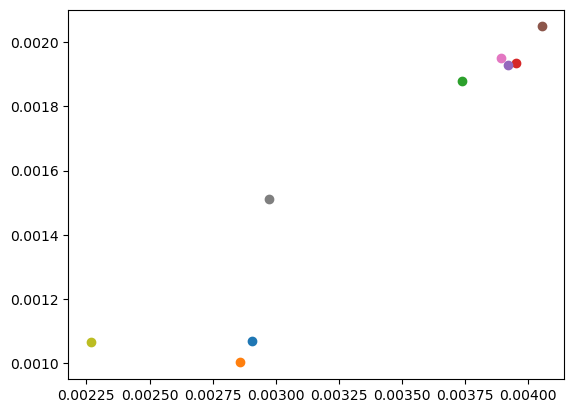

In [145]:
with open("series_resistances.pkl","rb") as handle:
    data = pickle.load(handle)
print(data.keys())
for volt in data.keys():
    # print("mean voltage ch1",volt,np.mean(data[volt][0][0]))
    # print("mean voltage ch2",volt,np.mean(data[volt][0][1]))
    print("ratio",np.mean(data[volt][0][0])/np.mean(data[volt][0][1]))
    plt.scatter(np.mean(data[volt][0][0]),np.mean(data[volt][0][1]))


(0.0, 0.01)

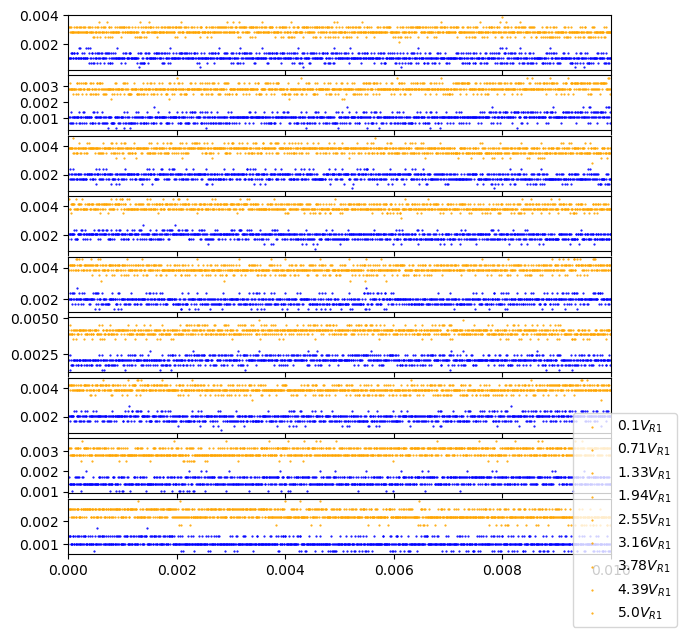

In [146]:
# For quickly checking the measured data. 

with open("series_resistances.pkl","rb") as handle:
    data = pickle.load(handle)

n_volt = data.keys()

fig, axes = plt.subplots(len(n_volt),1,figsize=(7,7),sharex=True)
fig.subplots_adjust(hspace=0.1)

for i,volt in enumerate(n_volt):
    # We only look at the first attempt at each volt. 
    v0 = data[volt][0][0]
    v1 = data[volt][0][1]
    axes[i].scatter(t,v0,color="orange",s=0.3,label=str(volt)+"$V_{R1}$")
    axes[i].scatter(t,v1,color="blue",s=0.3)#,label=str(volt)+"$V_{R2}$")
fig.legend(loc="lower right")
axes[0].set_xlim(0.0,0.01)
